# Objectives
In this Notebook, we will apply image augmentation to the dataset from the previous exercise hopefully we can allegiate overfitting.

After going through this notebook, you will be able to:
- Apply image augmentation

Requirments:
- Data used in this notebook are downloaded in the previous notebook.
- Install are mentionned in the exercise 1 as well.

# Requirements

This notebook should use torchvision and torch versions that are compatible with each other. For more information, visit [this link](https://pypi.org/project/torchvision/).

For demonstration purposes, we use the torch version 1.12.1 and the torchvision 0.13.1. However, users may install and use other versions.

In [1]:
#Env: azureml_py38_PT_TF
import torch
import torchvision
print('The version of PyTorch is {}'.format(torch.__version__))
print('The version of Torchvision is {}'.format(torchvision.__version__))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('There are {} cuda devices'.format(torch.cuda.device_count()))
print('Used device is {}'.format(device))

The version of PyTorch is 1.12.1
The version of Torchvision is 0.13.1
There are 1 cuda devices
Used device is cuda


# Common imports
The below improts are encountered in most of the computer vision projects. Though, you may need to adapt them according to your needs.

In [2]:
#Imports
import json, os, random
random.seed(1985)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import random


from tqdm import tqdm
from matplotlib.patches import Rectangle
from PIL import Image


from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.autograd import Variable
from torchvision.ops import nms


from torch_snippets import *
from project_utils import *


# Configuring some pathes to make it easier to call images and annotations

In [3]:
#The pathes on AzureML are a bit strange
full_path = os.getcwd().split('/')
#This will adapt the user name to your specific machine
home = os.path.join(os.path.expanduser('~'), 'cloudfiles/code/Users/' + full_path[11])
print('Home Directory - Full Path: {}\n'.format(home))

#The Notebook directory
notebook_home = os.path.join(home, 'computer_vision_with_azure_course/1_object_detection')
print('Notebbok Directory: {}\n'.format(notebook_home))

#The Notebook directory
images_home = os.path.join(home, 'data/rumex/images')
print('Images Directory: {}\n'.format(images_home))

#The Notebook directory
annotations_home = os.path.join(home, 'computer_vision_with_azure_course/1_object_detection/annotations')
print('Annotations Directory: {}\n'.format(annotations_home))

Home Directory - Full Path: /home/azureuser/cloudfiles/code/Users/roland.nasser.agroscope

Notebbok Directory: 
/home/azureuser/cloudfiles/code/Users/roland.nasser.agroscope/computer_vision_with_azure_course/1_object_detection

Images Directory: /home/azureuser/cloudfiles/code/Users/roland.nasser.agroscope/data/rumex/images

Annotations Directory: 
/home/azureuser/cloudfiles/code/Users/roland.nasser.agroscope/computer_vision_with_azure_course/1_object_detection/
annotations

# Loading annotations


In [4]:
#Test the function
annotations_link = os.path.join(annotations_home, 'annotations.csv')
df = load_clean_annotations(annotations_link, images_home)
df.head()

,Label,External ID
0,"{""Wurzelpunkt"":[{""geometry"":{""x"":821,""y"":424}}...",img_2001.png
1,"{""Wurzelpunkt"":[{""geometry"":{""x"":651,""y"":493}}...",img_2008.png
2,"{""Wurzelpunkt"":[{""geometry"":{""x"":545,""y"":699}}...",img_2009.png
3,"{""Wurzelpunkt"":[{""geometry"":{""x"":740,""y"":527}}...",img_2010.png
4,"{""Wurzelpunkt"":[{""geometry"":{""x"":697,""y"":666}}...",img_2011.png


# Image augmentation

In [16]:
import transforms as T

def get_transform(train):
    transforms = []
    #transforms.append(T.PILToTensor())
    #transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.7))
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomZoomOut())
        transforms.append(T.RandomPhotometricDistort())
        #transforms.append(T.ScaleJitter())
        #transforms.append(T.RandomShortestSize())
    return T.Compose(transforms)


In [17]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    #loss = Variable(loss, requires_grad = True) #Used in case grad is activated outside the loop
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses


In [18]:
from sklearn.model_selection import train_test_split

annotations_link = os.path.join(annotations_home, 'annotations.csv')
annotations_df = load_clean_annotations(annotations_link, images_home)


trn_ids, val_ids = train_test_split(df['External ID'].unique(), test_size=0.3, random_state=99)
trn_df, val_df = df[df['External ID'].isin(trn_ids)], df[df['External ID'].isin(val_ids)]

trn_df.reset_index(inplace = True, drop=True)
val_df.reset_index(inplace = True, drop=True)

print(len(trn_df))
print(len(val_df))

329

141

In [19]:
train_data = RumexDataSetLabelBox(images_home, trn_df, transforms=get_transform('train'))
val_data = RumexDataSetLabelBox(images_home, val_df)


In [20]:
train_loader = DataLoader(
        train_data,
        batch_size=4,
        shuffle=False,
        collate_fn=collate_fn
#        num_workers = 4, #rule of thumb (4 x number of GPUs),
#        pin_memory = True
    )

val_loader = DataLoader(
        val_data,
        batch_size=4,
        shuffle=False,
        collate_fn=collate_fn
  #      num_workers=4,
 #       pin_memory = True
    )

In [21]:
print('Make sure the device is a cuda device: \n Found device: {}'.format(device))
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
n_epochs = 20
log = Report(n_epochs) #From pytorch_snipets

Make sure the device is a cuda device: 
 Found device: cuda

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
import wandb
wandb.init(project='faster_rcnn_camera')

wandb: Currently logged in as: nasserai. Use `wandb login --relogin` to force relogin


In [23]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        

    _n = len(val_loader)
    for ix,inputs in enumerate(val_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
        [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
        
    if (epoch+1)%(n_epochs//5)==0:
        #call("nvidia-smi")
        log.report_avgs(epoch+1)

EPOCH: 2.964  trn_loss: 0.202  trn_loc_loss: 0.069  trn_regr_loss: 0.118  trn_objectness_loss: 0.008  trn_rpn_box_reg_loss: 0.006  (627.86s - 3608.90s remaining)

100%|██████████| 121/121 [00:00<00:00, 2256.65it/s]


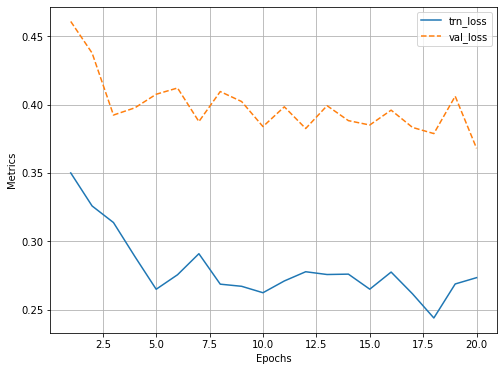

In [29]:
log.plot_epochs(['trn_loss','val_loss'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


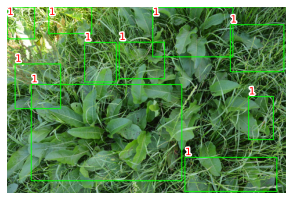

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


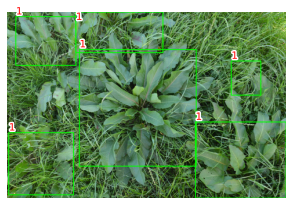

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


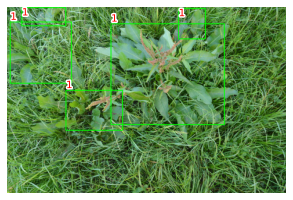

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


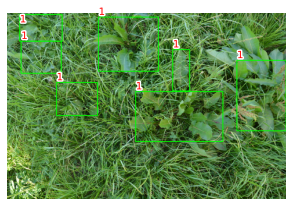

In [30]:
model.eval()
for ix, (images, targets) in enumerate(val_loader):
    if ix==1: break
    images = [im for im in images]
    outputs = model(images)
    
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        #print(bbs)
        #print(confs)
        #print(labels)
        #info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5) #Show from pytorch snippets

In [31]:
torch.save(model.state_dict(), "models/model_augmentation_2.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth

# Inference

In [32]:
model = get_model(num_classes= 2).to(device)
model.load_state_dict(torch.load("models/model_augmentation_2.pth"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


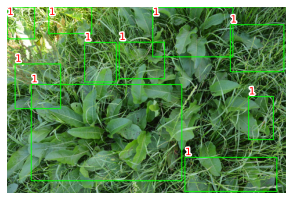

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


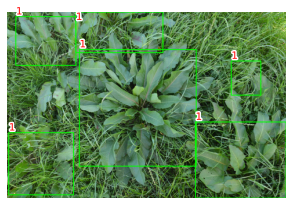

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


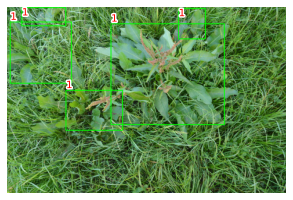

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


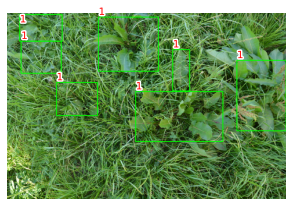

In [33]:
model.eval()
for ix, (images, targets) in enumerate(val_loader):
    if ix==1: break
    images = [im for im in images]
    #print(images)
    with torch.no_grad():
        outputs = model(images)
    
    
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        #print(bbs)
        #print(confs)
        #print(labels)
        #info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5) #Show from pytorch snippets
    